# Mô hình mạng Bayes với thư viện Causalex

**BS. Lê Ngọc Khả Nhi**

# Giới thiệu

Gần đây mới xuất hiện một thư viện mới là **causalex** của nhóm tác giả từ QuantumBlack Visual Analytics Lab. Thư viện này hỗ trợ cách tiếp cận bài toán suy luận nhân quả bằng mô hình mạng Bayes (Bayesian Network). Như những bài trước về dowhy hay EconML, lần này Nhi cũng làm một thử nghiệm thăm dò tính năng cơ bản của causalex.

In [40]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# Thao tác dữ liệu
import pandas as pd
import numpy as np

# Tiện ích
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Mô hình nhân quả
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from causalnex.evaluation import classification_report
from causalnex.inference import InferenceEngine

# Graphs
import networkx as nx

# Đồ họa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from graphviz import Source

# Thí nghiệm

Thí nghiệm này được dựa theo một phiên bản giản lược của bộ dữ liệu NHEFS kinh điển mà bạn có thể tải từ đây: https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/

Mục tiêu của thí nghiệm nhằm thiết lập một mô hình Bayesian network cho phép suy luận về liên hệ nhân quả giữa 15 biến/yếu tố, bao gồm: yếu tố can thiệp là "Bỏ hút thuốc lá" và "Thay đổi về mức tiêu thụ thuốc lá", cùng 12 đặc tính/bệnh lý nền tim mạch/hô hấp, và yếu tố kết cục là thay đổi cân nặng trong 10 năm trong một mẫu gồm 1566 người.

Nhi tạo ra 3 dictionaries gồm keys là tên viết tắt của các biến, mỗi tên lại tương ứng với một dictionary về quy tắc mã hóa (nếu là biến định tính, rời rạc).

## Chuẩn bị dữ liệu

In [2]:
intervention = {'qsmk':{0: 'N',1:'Y'},
                'smkintensity82_71':None,}
                 
background = {'sex':{0:'M',1:'F'},
              'active':{0:'High', 1:'Moderate', 2:'None'},
              'asthma':{0:'N',1:'Y'},
              'hbp':{0:'N',1:'Y',2:'Mis'},
              'hf':{0:'N',1:'Y'},
              'bronch':{0:'N',1:'Y'},
              'diabetes':{0:'N',1:'Y',2:'Mis'},
              'tumor':{0:'N',1:'Y'},
              'race':{0:'Wht',1:'Blk'},
              'weakheart':{0:'N',1:'Y'},
              'exercise':{0:'High',1:'Moderate',2:'None'},
              'hepatitis':{0:'N',1:'Y'},
             }

outcome = {'wt82_71':None}

Từ 3 dictionaries này, Nhi tạo 2 list gồm tên các biến và quy tắc mã hóa của chúng (None nếu là biến định lượng)

In [3]:
included = list(intervention.keys()) + list(background.keys()) + list(outcome.keys())
encoded = list(intervention.values()) + list(background.values()) + list(outcome.values())

Tiếp theo, Nhi tải dữ liệu, trích xuất riêng những biến cần sử dụng từ list included, loại bỏ hết các cases thiếu dữ liệu: có 1566 cá thể trong data sau cùng

In [4]:
data = pd.read_excel('NHEFS.xls')

data = data[included].dropna(axis = 0)
        
data.info()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 1628
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   qsmk               1566 non-null   int64  
 1   smkintensity82_71  1566 non-null   int64  
 2   sex                1566 non-null   int64  
 3   active             1566 non-null   int64  
 4   asthma             1566 non-null   int64  
 5   hbp                1566 non-null   int64  
 6   hf                 1566 non-null   int64  
 7   bronch             1566 non-null   int64  
 8   diabetes           1566 non-null   int64  
 9   tumor              1566 non-null   int64  
 10  race               1566 non-null   int64  
 11  weakheart          1566 non-null   int64  
 12  exercise           1566 non-null   int64  
 13  hepatitis          1566 non-null   int64  
 14  wt82_71            1566 non-null   float64
dtyp

In [5]:
data.head(5)

,qsmk,smkintensity82_71,sex,active,asthma,hbp,hf,bronch,diabetes,tumor,race,weakheart,exercise,hepatitis,wt82_71
0,0,-10,0,0,0,1,0,0,1,0,1,0,2,0,-10.093960
1,0,-10,0,0,0,0,0,0,0,0,0,0,0,0,2.604970
2,0,-14,1,0,0,0,0,0,0,1,1,0,2,0,9.414486
3,0,4,0,1,0,1,0,0,0,0,1,1,2,0,4.990117
4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,4.989251


## Xây dựng mô hình cấu trúc (DAG)

Công đoạn đầu tiên trong quy trình dựng mô hình BN, đó là Structural learning, ta phải thiết lập được cấu trúc một sơ đồ định hướng không theo chu trình (Directed Acyclic Graph), hay gọi tắt là DAG. 

Sơ đồ (graph) là một tập hợp các nút (nodes) và cạnh (edges), mỗi nút tương ứng với 1 yếu tố/biến, liên kết và đường nối kết giữa chúng thể hiện mối liên hệ các nhân tố này. Đồ thị có hướng (Directed graph) là đồ thị trong đó mỗi cạnh có định hướng (mũi tên), chỉ từ nút parent sang nút child). Đường dẫn trong đồ thị có hướng là một chuỗi các cạnh sao cho nút kết thúc của mỗi cạnh là nút bắt đầu của cạnh tiếp theo trong chuỗi. Chu trình là một con đường vòng khép kín mà nút khởi đầu của cạnh đầu tiên cũng là nút kết thúc của cạnh sau cùng. DAG là một đồ thị có định hướng nhưng không khép kín (không tạo ra chu trình).

Công đoạn thiết lập cấu trúc này thường được tiến hành trên toàn bộ dữ liệu, và kết hợp cả 2 tiến trình: khách quan : Học từ dữ liệu , và chủ quan (dựa vào kiến thức chuyên ngành và suy luận logic chủ quan của nghiên cứu sinh, trong đó NCS có quyền xóa bỏ liên kết mà họ cho là phi lý, hoặc cưỡng bức 2 nút nhất định bắt buộc phải liên kết với nhau theo hướng mà họ cho là hợp lý).

Bước đầu tiên trong quy trình này thường là liệt kê một danh sách đen, để loại bỏ những mũi tên (edges), những nút parents hoặc child mà ta không muốn xuất hiện trong mô hình. Thí dụ, Nhi không muốn bất cứ mũi tên nào đi từ Kết quả (ở đây là biến wt82-71 đến nguyên nhân (các biến còn lại).

In [7]:
tabu_lst = [('wt82_71',k) for k in intervention.keys()] + [('wt82_71',k) for k in background.keys()]

tabu_lst

[('wt82_71', 'qsmk'),
 ('wt82_71', 'smkintensity82_71'),
 ('wt82_71', 'sex'),
 ('wt82_71', 'active'),
 ('wt82_71', 'asthma'),
 ('wt82_71', 'hbp'),
 ('wt82_71', 'hf'),
 ('wt82_71', 'bronch'),
 ('wt82_71', 'diabetes'),
 ('wt82_71', 'tumor'),
 ('wt82_71', 'race'),
 ('wt82_71', 'weakheart'),
 ('wt82_71', 'exercise'),
 ('wt82_71', 'hepatitis')]

Sau đó, Nhi để cho thuật toán của thư viện causalnex tự động phân tích dữ liệu và đề xuất sơ đồ DAG, với một ngưỡng giới hạn về xác suất của các edges và nodes thí dụ 0.7 hay 0.8

Sau đó, một cách chủ quan, Nhi cưỡng bức liên hệ giữa smkintensity82_71 và wt82-71, như vậy smkintensity82_71 là 1 yếu tố trung gian nhưng cũng có thể là hệ quả của những biến khác

In [8]:
sm = from_pandas(data,
                 tabu_edges=tabu_lst,
                 w_threshold=0.7)

sm.add_edge("smkintensity82_71", "wt82_71")

sm = sm.get_largest_subgraph()

Kết quả cho ra sơ đồ như sau:

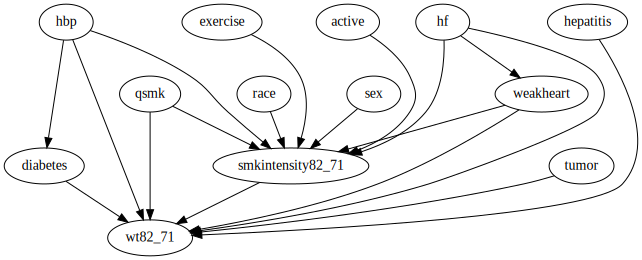

In [9]:
nx.drawing.nx_pydot.write_dot(sm, "sm.dot")

s = Source.from_file('sm.dot', engine = 'dot')

s

!['dag'](DAG.png)

Dĩ nhiên ta có thể hiệu chỉnh cấu trúc này một cách chủ quan bằng cách thêm, bớt node, liên kết... tùy thích, nhưng vì nội dung sơ đồ hiện nay cũng khá hợp lý nên Nhi không can thiệp xa hơn

## Khớp mô hình mạng Bayes

Sau khi có cấu trúc DAG, ta sẽ thực hiện suy diễn thống kê, nói cách khác là khớp mô hình mạng Bayes với cấu trúc là sơ đồ mạng trên với thông tin từ dữ liệu, mô hình này cho phép ước lượng xác suất của một child node (kết quả) dựa vào quan sát sự tồn tại của các node parents của nó. 

Ta khởi tạo 1 instance của class BayesianNetwork, từ sơ đồ cấu trúc sm (structural model)

In [12]:
bn = BayesianNetwork(sm)

Một giới hạn kỹ thuật của phương pháp Bayesian Network, đó là nó chỉ hoạt động tối ưu trên dữ liệu là biến rời rạc nhưng rất kém hiệu quả thậm chí thất bại trên dữ liệu là biến liên tục hay quá nhiều giá trị).

Do đó, ta cần định tính hóa dữ liệu, bằng cách :

1) Chuyển tất cả giá trị là con số thành nhãn tương ứng

2) Cắt biến định lượng liên tục thành những giá trị định tính

Thí dụ: Nhi cắt biến 'smkintensity82_71' thành 4 phần bằng nhau với ý nghĩa:

Max = Giảm tiêu thụ thuốc lá tối đa,

Down = Có giảm tiêu thụ thuốc lá nhưng ít,

Unch = Không thay đổi tiêu thụ,

Up = Hút nhiều hơn

Và cắt biến wt82_71 thành 3 phần bằng nhau:

Down = Giảm cân nặng,

Up = Tăng cân nặng,

Over = Tăng cân rất nhiều

ta cũng loại bỏ những trường hợp mà chẩn đoán diabetes và tăng huyết áp kg thể xác định (mã = 2)

In [13]:
discretised_data = data.copy()
discretised_data['smkintensity82_71'] = pd.qcut(discretised_data.smkintensity82_71, 
                                                4, 
                                                labels=["Max","Down","Unch","Up"])

discretised_data['wt82_71'] = pd.qcut(discretised_data.wt82_71, 3, labels=["Down","Up","Over"])

discretised_data = discretised_data[discretised_data.diabetes != 2]
discretised_data = discretised_data[discretised_data.hbp != 2]

for k,v in zip(included, encoded):
    
    if v != None:
        discretised_data[k] = discretised_data[k].map(v)

In [14]:
discretised_data

,qsmk,smkintensity82_71,sex,active,asthma,hbp,hf,bronch,diabetes,tumor,race,weakheart,exercise,hepatitis,wt82_71
0,N,Max,M,High,N,Y,N,N,Y,N,Blk,N,None,N,Down
1,N,Max,M,High,N,N,N,N,N,N,Wht,N,High,N,Up
2,N,Max,F,High,N,N,N,N,N,Y,Blk,N,None,N,Over
3,N,Up,M,Moderate,N,Y,N,N,N,N,Blk,Y,None,N,Up
4,N,Unch,M,Moderate,N,N,N,N,N,N,Wht,N,Moderate,N,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,N,Down,M,Moderate,N,N,N,N,N,N,Wht,N,Moderate,N,Down
834,N,Max,F,Moderate,Y,N,N,N,N,N,Wht,N,None,N,Down
835,N,Unch,F,Moderate,N,N,N,N,N,N,Wht,N,None,N,Down
836,N,Max,F,Moderate,N,N,N,N,N,Y,Wht,N,Moderate,N,Down


Nhi cắt dữ liệu vừa tạo thành 2 phần: tập train 90% và tập test 10%:

In [15]:
train, test = train_test_split(discretised_data, 
                               train_size=0.9, 
                               test_size=0.1,
                               random_state=3)

Khớp mô hình BN trên tập train...

In [19]:
bn = bn.fit_node_states(discretised_data)

In [20]:
bn = bn.fit_cpds(train,
                 method="BayesianEstimator", 
                 bayes_prior="K2")

## Suy diễn thống kê

Mô hình BN có thể sử dụng theo 2 cách: Diễn dịch (Inference) hoặc Tiên lượng (Predictive);

Cho mục tiêu suy diễn thống kê, ta có thể dùng method cpds để xác định xác suất có điều kiện (conditional probability distributions) cho bất cứ một node mục tiêu nào, từ tất cả tổ hợp giá trị có thể của những node parents của nó.

Thí dụ nếu Nhi quan tâm đến node smkintensity82_71:

In [21]:
bn.cpds['smkintensity82_71'].T

smkintensity82_71                                   Down       Max      Unch  \
active exercise hbp hf qsmk race sex weakheart                                 
High   High     N   N  N    Blk  F   N          0.200000  0.200000  0.400000   
                                     Y          0.250000  0.250000  0.250000   
                                 M   N          0.111111  0.222222  0.222222   
                                     Y          0.250000  0.250000  0.250000   
                            Wht  F   N          0.083333  0.125000  0.375000   
...                                                  ...       ...       ...   
None   None     Y   Y  Y    Blk  M   Y          0.250000  0.250000  0.250000   
                            Wht  F   N          0.250000  0.250000  0.250000   
                                     Y          0.250000  0.250000  0.250000   
                                 M   N          0.250000  0.250000  0.250000   
                                     Y          0.250000  0.250000  0.250000   

smkintensity82_71                                     Up  
active exercise hbp hf qsmk race sex weakheart            
High   High     N   N  N    Blk  F   N          0.200000  
                                     Y          0.250000  
                                 M   N          0.444444  
                                     Y          0.250000  
                            Wht  F   N          0.416667  
...                                                  ...  
None   None     Y   Y  Y    Blk  M   Y          0.250000  
                            Wht  F   N          0.250000  
                                     Y          0.250000  
                                 M   N          0.250000  
                                     Y          0.250000  

[576 rows x 4 columns]

Tương tự cho node wt82_71:

In [22]:
bn.cpds['wt82_71'].T

wt82_71                                                               Down  \
diabetes hbp hepatitis hf qsmk smkintensity82_71 tumor weakheart             
N        N   N         N  N    Down              N     N          0.367647   
                                                       Y          0.250000   
                                                 Y     N          0.500000   
                                                       Y          0.333333   
                               Max               N     N          0.325301   
...                                                                    ...   
Y        Y   Y         Y  Y    Unch              Y     Y          0.333333   
                               Up                N     N          0.333333   
                                                       Y          0.333333   
                                                 Y     N          0.333333   
                                                       Y          0.333333   

wt82_71                                                               Over  \
diabetes hbp hepatitis hf qsmk smkintensity82_71 tumor weakheart             
N        N   N         N  N    Down              N     N          0.352941   
                                                       Y          0.500000   
                                                 Y     N          0.166667   
                                                       Y          0.333333   
                               Max               N     N          0.277108   
...                                                                    ...   
Y        Y   Y         Y  Y    Unch              Y     Y          0.333333   
                               Up                N     N          0.333333   
                                                       Y          0.333333   
                                                 Y     N          0.333333   
                                                       Y          0.333333   

wt82_71                                                                 Up  
diabetes hbp hepatitis hf qsmk smkintensity82_71 tumor weakheart            
N        N   N         N  N    Down              N     N          0.279412  
                                                       Y          0.250000  
                                                 Y     N          0.333333  
                                                       Y          0.333333  
                               Max               N     N          0.397590  
...                                                                    ...  
Y        Y   Y         Y  Y    Unch              Y     Y          0.333333  
                               Up                N     N          0.333333  
                                                       Y          0.333333  
                                                 Y     N          0.333333  
                                                       Y          0.333333  

[512 rows x 3 columns]

Ngoài ra, ta có method InferenceEngine cho phép xác định marginal effects trên 1 kết quả

In [48]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["smkintensity82_71"]

{'Down': 0.18660340780021864,
 'Max': 0.31172301427032356,
 'Unch': 0.24671387070826387,
 'Up': 0.254959707221194}

In [49]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals['wt82_71']

{'Down': 0.34034667701771293,
 'Over': 0.32138464304536435,
 'Up': 0.33826867993692405}

Ta có thể khảo sát hiệu ứng marginal của bỏ hút thuốc đối với thay đổi cân nặng:

In [50]:
quit = ie.query({'qsmk': "Y"})
no_quit = ie.query({'qsmk': "N"})

print("Thay đổi cân nặng | Bỏ hút thuốc", quit['wt82_71'])
print("Thay đổi cân nặng | Không bỏ hút thuốc", no_quit['wt82_71'])

Thay đổi cân nặng | Bỏ hút thuốc {'Down': 0.2864593309317721, 'Over': 0.3930198460875881, 'Up': 0.3205208229806398}
Thay đổi cân nặng | Không bỏ hút thuốc {'Down': 0.36068347237964793, 'Over': 0.2943499016673599, 'Up': 0.3449666259529922}


## Can thiệp cưỡng bức : do calculus

Cách diễn giải nêu trên chỉ khảo sát được xác suất có điều kiện trên dữ liệu được quan sát, nhưng không giải quyết được vấn đề phản thực tế; 

Để trả lời câu hỏi What if "Nếu 1 người bỏ hút thuốc thì câng nặng sẽ thay đổi ra sao ?", ta sẽ áp dụng do calculus hay cưỡng bức can thiệp bỏ hút thuốc = Yes 

In [51]:
print("Hiếu ứng trước can thiệp cưỡng bức", ie.query()["wt82_71"])

ie.do_intervention("qsmk", 
                   {'Y': 1, 
                    'N': 0})

print("Hiệu ứng can thiệp cưỡng bức", ie.query()["wt82_71"])

Hiếu ứng trước can thiệp cưỡng bức {'Down': 0.34034667701771293, 'Over': 0.32138464304536435, 'Up': 0.33826867993692405}
Hiệu ứng can thiệp cưỡng bức {'Down': 0.28645933093177206, 'Over': 0.39301984608758794, 'Up': 0.3205208229806397}


Có thể diễn giải kết quả này là: Nếu 100% trường hợp đều bỏ hút thuốc, xác suất Tăng cân (Over + Up) sẽ tăng từ 0.659 lên 0.713

In [53]:
0.32138464304536435 + 0.338268679936924, 0.39301984608758794 + 0.3205208229806397

(0.6596533229822883, 0.7135406690682277)

## Tiên lượng/dự báo

Công dụng thứ 2 của mô hình BN, đó là nó có thể được dùng như mọi mô hình Machine learning Classification khác, xác định nhãn của 1 node mục tiêu cho 1 cá thể bất kì, nếu biết trạng thái của các node parents trong sơ đồ DAG của cá thể đó.

Dự báo cho toàn bộ tập test:

In [24]:
target = 'smkintensity82_71'

int_test_pred = bn.predict(test,target)

int_test_pred

,smkintensity82_71_prediction
84,Max
367,Up
605,Unch
225,Up
421,Up
...,...
105,Up
76,Unch
675,Up
662,Unch


Tương tự cho kết quả wt82_71:

In [25]:
target = 'wt82_71'

wc_test_pred = bn.predict(test,target)

wc_test_pred

,wt82_71_prediction
84,Down
367,Up
605,Up
225,Up
421,Up
...,...
105,Up
76,Up
675,Up
662,Up


method classification_report cho phép lượng giá hiệu năng dự báo của mô hình:

In [26]:
target = 'smkintensity82_71'

classification_report(bn, test, target)

{'smkintensity82_71_Down': {'precision': 0.4,
  'recall': 0.36363636363636365,
  'f1-score': 0.380952380952381,
  'support': 11},
 'smkintensity82_71_Max': {'precision': 0.5882352941176471,
  'recall': 0.37037037037037035,
  'f1-score': 0.45454545454545453,
  'support': 27},
 'smkintensity82_71_Unch': {'precision': 0.24,
  'recall': 0.25,
  'f1-score': 0.24489795918367346,
  'support': 24},
 'smkintensity82_71_Up': {'precision': 0.17857142857142858,
  'recall': 0.2777777777777778,
  'f1-score': 0.21739130434782608,
  'support': 18},
 'accuracy': 0.3125,
 'macro avg': {'precision': 0.3517016806722689,
  'recall': 0.3154461279461279,
  'f1-score': 0.3244467747573338,
  'support': 80},
 'weighted avg': {'precision': 0.3657079831932773,
  'recall': 0.3125,
  'f1-score': 0.3281724745234062,
  'support': 80}}

In [27]:
target = 'wt82_71'

classification_report(bn, test, target)

{'wt82_71_Down': {'precision': 0.4117647058823529,
  'recall': 0.2413793103448276,
  'f1-score': 0.3043478260869565,
  'support': 29},
 'wt82_71_Over': {'precision': 0.46153846153846156,
  'recall': 0.21428571428571427,
  'f1-score': 0.2926829268292683,
  'support': 28},
 'wt82_71_Up': {'precision': 0.36,
  'recall': 0.782608695652174,
  'f1-score': 0.4931506849315068,
  'support': 23},
 'accuracy': 0.3875,
 'macro avg': {'precision': 0.4111010558069381,
  'recall': 0.4127579067609053,
  'f1-score': 0.3633938126159106,
  'support': 80},
 'weighted avg': {'precision': 0.4143031674208145,
  'recall': 0.3875,
  'f1-score': 0.35454593326457384,
  'support': 80}}

Ta thử kiểm tra 1 trường hợp

In [36]:
i = 10

print(f"Trường hợp {i} tập test: dự báo = {int_test_pred.iloc[i,0]}")
print(f"Quan sát thực tế = {test.iloc[10,-1]}")

Trường hợp 10 tập test: dự báo = Down
Quan sát thực tế = Down


method roc_auc cho phép ước tính AUC đường cong ROC cho một mục tiêu:

In [38]:
roc, auc = roc_auc(bn, test, "smkintensity82_71")
print(auc)

0.688203125


Có vẻ như mô hình Bayesian network hiện thời không có khả năng dự báo đáng tin cậy, nó chỉ dừng lại ở công dụng suy luận nhân quả

# Nhận định

Thư viện causalex khá tốt, so với các thư viện về Bayesian network và DAG mà Nhi từng dùng trong ngôn ngữ R, nó có cú pháp khá đơn giản, hỗ trợ đầy đủ các công đoạn cần thiết cho 1 quy trình dựng mô hình mạng Bayes, suy luận thống kê và có thêm tính năng dự báo (dù độ chính xác dự báo không mấy ấn tượng).

Bayesian network và structural learning là một kỹ thuật khó, nó không phải là một thuật toán thần kì, cho phép vẽ ra ngay một sơ đồ DAG từ dữ liệu, nhưng đòi hỏi sự phối hợp giữa người và máy tính, kết hợp kiến thức chuyên môn, giả thuyết tốt, suy luận chủ quan hợp lý và dữ liệu tốt, nói cách khác là sự can thiệp có trách nhiệm của người dùng.